# 0） Gererate the Data and Preparation

In [33]:
import numpy as np
import cvxpy as cp
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
seaborn.set()

Set the random seed for reproducibility

In [236]:
# for reproducibility
random.seed(4300)

n = 10000    # number of bidders
m = 10       # type of resources
p = np.array([float(random.randint(10,50)) for i in range(m)])      # ground truth price vector
A = np.random.randint(0, high = 2, size = (m, n))

pi = p.T@A
for i in range(n):
    pi[i] += random.gauss(0, 0.2)

b = np.array([1000.0]*10).reshape(-1,1)
pi = np.array(pi).reshape(-1,1)

print(f'Ground Truth Price: {p}')
print(f'The shape of A :  {A.shape}')
print(f'The shape of pi:  {pi.shape}')
print(f'The shape of b :  {b.shape}')
print(f'The dtype of A :  {A.dtype}')
print(f'The dtype of pi:  {pi.dtype}')
print(f'The dtype of b :  {b.dtype}')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Ground Truth Price: [42. 40. 13. 28. 14. 45. 44. 35. 32. 49.]
The shape of A :  (10, 10000)
The shape of pi:  (10000, 1)
The shape of b :  (10, 1)
The dtype of A :  int64
The dtype of pi:  float64
The dtype of b :  float64


# 1) One-time Online Learning (SLPM)

## Offline Learning

In [97]:
x = cp.Variable((n,1))
objective = cp.Maximize(pi.T@x)
constraints = [A@x <= b, x >= 0, x <= 1]
prob = cp.Problem(objective, constraints)

prob.solve()

opv1 = prob.value
x = np.where(x.value >= 0.5, 1, 0)

print(f'Optimal Solution: \n{x[:,0].T}')
print(f'Optimal Value: {opv1}')

Optimal Solution: 
[0 1 0 ... 0 0 0]
Optimal Value: 342578.0178830947


## One-time Online Learning (SLPM) Algorithm Implement and Sensitivity Analysis

In [98]:
def online_learning_SLPM(A, pi, b, n, k):
  # solve the dual SLPM with k bidders 
  m = len(b)
  y = cp.Variable((m+k,1))
  A_prime = np.hstack([A[:,:k].T, np.eye(k)])
  b_prime = np.append((k/n)*b,np.ones(k)).reshape(1,-1)
  pi_prime = pi[:k,:]
  objective = cp.Minimize(b_prime@y)
  constraints = [A_prime@y >= pi_prime, y >= 0]
  prob = cp.Problem(objective, constraints)
  prob.solve()

  # obtain the dual prices
  P = y[:m,:].value
  
  # proposal of x
  x = np.where(pi>A.T@P,1,0)
  x[:k,:] = 0
  # output x
  sold = np.zeros_like(b)
  for i in range(k,n):
    if ((A[:,i].T*x[i,:]).reshape(-1,1) > b-sold).any():
      x[i,:] = 0
    else: sold += (A[:,i].T*x[i,:]).reshape(-1,1)

  # ouptut the optimal revenue
  revenue = (pi.T@x)[0,0]
  return P, x, revenue


In [99]:
print('-'*25 + 'One-time Online Learning SLPM' + '-'*25 + '\n')
for k in [50, 100, 200]:
  P,x,r = online_learning_SLPM(A,pi,b,10000,k)
  print('-'*25 + f'k = {k}' + '-'*25 + '\n')
  print(f'Dual price: {P.T[0,:]} \n')
  print(f'Allocation: {x.T[0,:]} \n')
  print(f'Revenue: {r} \n')
  print(f'Ratio: {r/opv1} \n')

-------------------------One-time Online Learning SLPM-------------------------

-------------------------k = 50-------------------------

Dual price: [42.09524933 40.07830557 12.91890055 28.13841729 14.12850993 44.97120076
 44.29096608 34.75537615 31.92627561 48.83908168] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 281924.5262591263 

Ratio: 0.8229498436625712 

-------------------------k = 100-------------------------

Dual price: [42.02542953 40.02410356 12.97687624 28.0136053  14.0214921  45.07902658
 44.10853032 34.9971968  31.9860877  49.02810338] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 317777.0358779295 

Ratio: 0.9276048645548862 

-------------------------k = 200-------------------------

Dual price: [42.06679891 39.98613229 13.0452631  27.98828437 14.06365282 44.98599629
 44.07049988 34.99895155 32.02794355 49.06377563] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 306509.3148007253 

Ratio: 0.8947139010691635 



## Comments

As k increasing, the ratio of the generated revenue over the offline revenue increases. 

Trade-off:---------------------------------------------------------------------------

# 2) Dynamic Learning (SLPM)

## Dynamic Learning (SLPM) Algorithm Implement

In [237]:
def dynamic_learning_SLPM(A, pi, b, n, k):
  global x_out
  x_out = np.zeros_like(pi)
  kk = k
  m = len(b)
  print('-'*30 + 'The Track of Dual Price' + '-'*30 + '\n')
  while kk < n:
    # solve the dual SLPM with kk bidders 
    y = cp.Variable((m+kk,1))
    A_prime = np.hstack([A[:,:kk].T, np.eye(kk)])
    b_prime = np.append((kk/n)*b,np.ones(kk)).reshape(1,-1)
    pi_prime = pi[:kk,:]
    objective = cp.Minimize(b_prime@y)
    constraints = [A_prime@y >= pi_prime, y >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # obtain the dual prices
    P = y[:m,:].value
    print('-'*25 + f'k = {kk}', '-'*25 + '\n')
    print(f'Dual price: {P.T[0,:]}\n')

    # proposal of x
    x = np.where(pi>A.T@P,1,0)
    x[:kk,:] = x_out[:kk,:]

    # update x
    sold = A[:,:kk]@x_out[:kk,:]
    for i in range(kk,min(2*kk, n)):
      if ((A[:,i].T*x[i,:]).reshape(-1,1) > b-sold).any():
        x[i,:] = 0
      else: sold += (A[:,i].T*x[i,:]).reshape(-1,1)
    
    # update x_out
    x_out[kk:min(2*kk, n),:] = x[kk:min(2*kk, n),:]

    # update kk
    kk += kk
  
  # ouptut the optimal revenue
  revenue = (pi.T@x_out)[0,0]
  print('-'*40 + 'END' + '-'*40)
  return P, x_out, revenue

In [238]:
P,x,r = dynamic_learning_SLPM(A, pi, b, 10000, 50)

------------------------------The Track of Dual Price------------------------------

-------------------------k = 50 -------------------------

Dual price: [41.92470215 39.93611369 13.09183905 28.03852328 13.99035868 45.03170535
 44.01460259 35.09950145 32.07536296 48.9852754 ]

-------------------------k = 100 -------------------------

Dual price: [41.95153609 39.98734707 13.13385514 28.04136026 13.95122006 45.03314122
 43.96470978 35.09612411 32.02607105 49.07449758]

-------------------------k = 200 -------------------------

Dual price: [41.98581702 40.07091166 13.04621869 28.03355083 13.98906852 45.00992688
 44.00239452 35.05057191 32.05004197 49.05893684]

-------------------------k = 400 -------------------------

Dual price: [42.04300156 40.05546711 13.03985182 28.05187972 14.02526828 45.0540577
 43.9819837  35.04163749 32.00933121 49.02082852]

-------------------------k = 800 -------------------------

Dual price: [42.02744793 40.03691966 13.03373219 28.08422506 14.00911624 

In [239]:
# groud truth dual price
y = cp.Variable((m+n,1))
A_prime = np.hstack([A.T, np.eye(n)])
b_prime = np.append(b,np.ones(n)).reshape(1,-1)
pi_prime = pi
objective = cp.Minimize(b_prime@y)
constraints = [A_prime@y >= pi_prime, y >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()
print(f'The optimal revenue: {prob.value}')
print(f'The ground truth dual price: \n{y.value[:10,:].T[0,:]}')

The optimal revenue: 342576.73361144733
The ground truth dual price: 
[42.02968075 40.03323076 13.03043518 28.05147507 14.03079998 45.03609215
 44.02421831 35.03256109 32.02375631 49.0269159 ]


In [240]:
print('-'*30 + 'Dynamic Learning SCLM' + '-'*30 + '\n')
print(f'Dual price: {P.T[0,:]} \n')
print(f'Allocation: {x.T[0,:]} \n')
print(f'Revenue: {r} \n')
print(f'Ratio: {r/opv1} \n')

------------------------------Dynamic Learning SCLM------------------------------

Dual price: [42.03257378 40.03448651 13.02197293 28.04838184 14.0279296  45.03120455
 44.02360368 35.03773103 32.02681347 49.02924428] 

Allocation: [0. 0. 0. ... 0. 0. 0.] 

Revenue: 332196.80191494554 

Ratio: 0.9104691367029145 



## Comments

--------------------------------------------------

# 3) Proof

# 4) One-time Online Learning (SCPM)

## One-time Online Learning (SCPM) Algorithm Implement

In [107]:
!pip install SCS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
def online_learning_SCPM(A, pi, b, n, k, w):
  # solve the primal SCPM with k bidders 
  m = len(b)
  b = b.reshape(m)
  y = cp.Variable(k)
  s = cp.Variable(m)
  objective = cp.Maximize(pi[:k,:].T@y + (w/m)*cp.sum(cp.log(s)))
  constraints = [A[:,:k]@y + s <= (k/n)*b, y >= 0, y <= 1]
  prob = cp.Problem(objective, constraints)
  prob.solve(cp.SCS)

  # obtain the dual prices
  P = prob.constraints[0].dual_value.reshape(-1,1)
  
  # proposal of x
  x = np.where(pi>A.T@P,1,0)
  x[:k,:] = 0

  # output x
  b = b.reshape(-1,1)
  sold = np.zeros_like(b)
  for i in range(k,n):
    if ((A[:,i].T*x[i,:]).reshape(-1,1) > b-sold).any():
      x[i,:] = 0
    else: sold += (A[:,i].T*x[i,:]).reshape(-1,1)

  # ouptut the optimal revenue
  revenue = (pi.T@x)[0,0]
  return P, x, revenue


In [109]:
print('-'*25 + 'One-time Online Learning SCPM' + '-'*25 + '\n')
for k in [50, 100, 200]:
  P,x,r = online_learning_SCPM(A,pi,b,10000,k,1)
  print('-'*25 + f'k = {k}' + '-'*25 + '\n')
  print(f'Dual price: {P.T[0,:]} \n')
  print(f'Allocation: {x.T[0,:]} \n')
  print(f'Revenue: {r} \n')
  print(f'Ratio: {r/opv1} \n')

-------------------------One-time Online Learning SCPM-------------------------

-------------------------k = 50-------------------------

Dual price: [42.06770631 40.10714237 12.92484833 28.13697838 14.15863824 44.97028194
 44.28784445 34.75320574 31.92694416 48.83793752] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 279662.73057159677 

Ratio: 0.8163475645627447 

-------------------------k = 100-------------------------

Dual price: [42.02434697 40.02468626 12.9844493  28.01795766 14.02081891 45.08097233
 44.11135886 34.99078378 31.98000138 49.02827477] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 317256.40167255903 

Ratio: 0.9260851108690321 

-------------------------k = 200-------------------------

Dual price: [42.06159088 39.99277259 13.04380863 27.98956097 14.0628219  44.98753668
 44.07110124 34.9985111  32.02804375 49.06328834] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 309527.8667653154 

Ratio: 0.9035251843594421 



## Comments

# 5) Dynamic Learning (SCPM)

## Dynamic Learning (SCPM) Algorithm Implement

In [110]:
def dynamic_learning_SCPM(A, pi, b, n, k, w):
  global x_out
  x_out = np.zeros_like(pi)
  kk = k
  m = len(b)
  print('-'*30 + 'The Track of Dual Price' + '-'*30 + '\n')
  while kk < n:
    # solve the primal SCPM with k bidders 
    b = b.reshape(m)
    y = cp.Variable(kk)
    s = cp.Variable(m)
    objective = cp.Maximize(pi[:kk,:].T@y + (w/m)*cp.sum(cp.log(s)))
    constraints = [A[:,:kk]@y + s <= (kk/n)*b, y >= 0, y <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve(cp.SCS)

    # obtain the dual prices
    P = prob.constraints[0].dual_value.reshape(-1,1)
    print('-'*25 + f'k = {kk}', '-'*25 + '\n')
    print(f'Dual price: {P.T[0,:]}\n')

    # proposal of x
    x = np.where(pi>A.T@P,1,0)
    x[:kk,:] = x_out[:kk,:]
    
    # update x
    b = b.reshape(-1,1)
    sold = A[:,:kk]@x_out[:kk,:]
    for i in range(kk,min(2*kk, n)):
      if ((A[:,i].T*x[i,:]).reshape(-1,1) > b-sold).any():
        x[i,:] = 0
      else: sold += (A[:,i].T*x[i,:]).reshape(-1,1)
    
    # update x_out
    x_out[kk:min(2*kk, n),:] = x[kk:min(2*kk, n),:]

    # update kk
    kk += kk
  
  # ouptut the optimal revenue
  revenue = (pi.T@x_out)[0,0]
  print('-'*40 + 'END' + '-'*40)
  return P, x_out, revenue

In [111]:
P,x,r = dynamic_learning_SCPM(A, pi, b, 10000, 50, 1)

------------------------------The Track of Dual Price------------------------------

-------------------------k = 50 -------------------------

Dual price: [42.06770631 40.10714237 12.92484833 28.13697838 14.15863824 44.97028194
 44.28784445 34.75320574 31.92694416 48.83793752]

-------------------------k = 100 -------------------------

Dual price: [42.02434697 40.02468626 12.9844493  28.01795766 14.02081891 45.08097233
 44.11135886 34.99078378 31.98000138 49.02827477]

-------------------------k = 200 -------------------------

Dual price: [42.06159088 39.99277259 13.04380863 27.98956097 14.0628219  44.98753668
 44.07110124 34.9985111  32.02804375 49.06328834]

-------------------------k = 400 -------------------------

Dual price: [42.01838815 39.96858886 13.03110248 28.03886347 14.07715188 45.00940824
 44.08207999 35.02531801 32.00801841 49.04628453]

-------------------------k = 800 -------------------------

Dual price: [42.02994343 40.00120455 13.02055544 28.03029639 14.05309548

In [112]:
# groud truth dual price
w = 1
b = b.reshape(m)
y = cp.Variable(n)
s = cp.Variable(m)
objective = cp.Maximize(pi[:,:].T@y + (w/m)*cp.sum(cp.log(s)))
constraints = [A@y + s <= b, y >= 0, y <= 1]
prob = cp.Problem(objective, constraints)
prob.solve(cp.SCS)
b = b.reshape(-1,1)
print(f'The optimal revenue: {prob.value}')
print(f'The ground truth dual price: \n{prob.constraints[0].dual_value}')

The optimal revenue: 342571.2648508994
The ground truth dual price: 
[42.03118605 40.02613658 13.02447837 28.03943959 14.03186248 45.03076422
 44.02694688 35.02879459 32.03610367 49.0415067 ]


In [113]:
print('-'*30 + 'Dynamic Learning SCPM' + '-'*30 + '\n')
print(f'Dual price: {P.T[0,:]} \n')
print(f'Allocation: {x.T[0,:]} \n')
print(f'Revenue: {r} \n')
print(f'Ratio: {r/opv1} \n')

------------------------------Dynamic Learning SCPM------------------------------

Dual price: [42.0298827  40.02679994 13.0273968  28.03990943 14.02725631 45.03221061
 44.03203465 35.01947016 32.03856441 49.04343053] 

Allocation: [0. 0. 0. ... 0. 0. 0.] 

Revenue: 332787.48511808814 

Ratio: 0.971421012867359 



## Comments

--------------------------------------

# 6) Action-history-dependent Learning Algorithm

In [ ]:
def aciton_history_dependent_learning(A, pi, b, n):
  # initialization
  bb = b
  P = np.zeros_like(b)
  x = np.zeros_like(pi)
  m = len(b)
  for k in range(n):
    # update allocation and remaining resource each iteration
    if pi[k,0] > (A[:,k]@P)[0] and (A[:,k].reshape(-1,1) <= bb).all():
      # determine the value of x at time point k
      x[k,:] = 1 
      # update the remaining resource bb
      bb = bb - A[:,k].reshape(-1,1)
    else: x[k,:] = 0
    
    # exit the loop
    if k == n-1: break

    # solve the dual SLPM with k bidders observed 
    y = cp.Variable((m+k+1,1))
    A_prime = np.hstack([A[:,:k+1].T, np.eye(k+1)])
    b_prime = np.append(((k+1)/(n-k-1))*bb,np.ones(k+1)).reshape(1,-1)
    pi_prime = pi[:k+1,:]
    objective = cp.Minimize(b_prime@y)
    constraints = [A_prime@y >= pi_prime, y >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # update the dual prices
    P = y[:m,:].value

    # keep track of the program
    if k%1000 == 0:
      print('-'*30 + f'k = {k}' + '-'*30)
      print(f'current remaining goods: {bb.T}')
      print(f'current dual price: {P.T}')
      print(f'current allocated number: {int(np.sum(x))}')

  # ouptut the optimal revenue
  revenue = (pi.T@x)[0,0]
  return P, x, revenue


In [ ]:
P,x,r = aciton_history_dependent_learning(A, pi, b, 10000)

------------------------------k = 0------------------------------
current remaining goods: [[ 999 1000  999  999 1000  999  999  999 1000 1000]]
current dual price: [[2.81621214e+01 7.17660165e-09 2.81621214e+01 2.81621214e+01
  7.17660165e-09 2.81621214e+01 2.81621214e+01 2.81621214e+01
  7.17660165e-09 7.17660165e-09]]
current allocated number: 1
------------------------------k = 1000------------------------------
current remaining goods: [[886 885 885 896 889 880 892 888 886 891]]
current dual price: [[44.08902159 35.07693621 14.10157764 49.05961068 25.08402291 26.06919854
  10.11546797 25.05775621 13.94293721 39.13464773]]
current allocated number: 245
------------------------------k = 2000------------------------------
current remaining goods: [[781 795 800 802 796 790 805 789 776 803]]
current dual price: [[44.12160125 35.0559864  14.06601746 49.05462079 25.06934173 26.06791338
  10.08272049 25.08168653 14.04554555 39.06314697]]
current allocated number: 460
---------------------

In [ ]:
print(f'Dual price: {P.T[0,:]} \n')
print(f'Allocation: {x.T[0,:]} \n')
print(f'Revenue: {r} \n')
print(f'Ratio: {r/opv1} \n')

Dual price: [-7.52614192e-12  2.07950030e+02  5.18685355e-09 -1.46000226e-09
 -1.33127880e-09  6.64775919e-09  1.82535329e+02  1.98449259e+02
  2.91051566e-10  2.12017821e+02] 

Allocation: [1. 1. 0. ... 0. 0. 0.] 

Revenue: 281827.81100056745 

Ratio: 0.9984331904608402 



# 7) Proof

# 8) Dynamic Online Learning with SGD

In [ ]:
#initialization
A = pd.read_csv("A.csv")
pi = pd.read_csv("pi.csv")
A = np.array(A)
pi  = np.array(pi)
pi = pi.T
print(pi.shape)
n = 10000
m = 10
b_i = 1000
k = 50
b = np.array([1000 for _ in range(m)])  

x = cp.Variable(k)
s = cp.Variable(m)


(1, 10000)


In [ ]:
print(A.shape)
print(b.shape)
print(pi.shape)

(10, 10000)
(10,)
(1, 10000)


In [ ]:
l_decision = []
b_k = b.copy()
d = b/n
rev = 0.0
price = np.array([0.0 for _ in range(m)])
for k in range(0,n):
    # Decide whether to accept (k)th request and the remaining resource
    if pi[0][k] > A[:,k].dot(price) and np.min(b_k - A[:,k]) >= 0:
        x = 1
        b_k -=  A[:,k]
    else:
        x = 0
    l_decision.append(x)
    rev += x*pi[0][k]
    # update price first
    grad = d - A[:,k]*np.heaviside((pi[0][k]-np.dot(A[:,k],price)),0.)
    price = np.maximum(price - grad/np.sqrt(k+1), 0.)

In [ ]:
x = cp.Variable(n)
ee = np.ones(n)
objective = cp.Maximize(pi@x)
constraints = [A@x <= b, x >= 0, x <= ee]
prob = cp.Problem(objective, constraints)

prob.solve()
x.value
opv1 = prob.value
print(opv1)

282270.0744458285


In [ ]:
opv2 = rev
print("optimal value:", opv2)
print("competetive ratio", opv2/opv1)


optimal value: 256570.91785383492
competetive ratio 0.9089554334002714


# 9) More General Setting

## Generate Dependent Data

In [254]:
# dependent data: Brownian Motion
class Brownian():
  def __init__(self, x0=0, alpha=5):
    self.x0 = float(x0)
    self.alpha = float(alpha)

  def gen_random_walk(self, n):
    w = np.ones(n)*self.x0
    for i in range(1, n):
      if w[i-1] > self.x0/10:
        w[i] = w[i-1] + (self.alpha*np.random.choice([-1,1])/np.sqrt(n))
      else: w[i] = self.x0/10 + np.abs(self.alpha*np.random.choice([-1,1])/np.sqrt(n))
    return w

  def gen_normal(self, n):
    w = np.ones(n)*self.x0
    for i in range(1, n):
      if w[i-1] > self.x0/10:
        w[i] = w[i-1] + (self.alpha*np.random.normal()/np.sqrt(n))
      else: w[i] = self.x0/10 + np.abs(self.alpha*np.random.normal()/np.sqrt(n))
    return w

In [255]:
print(f'Ground Truth Price: {p}')

Ground Truth Price: [42. 40. 13. 28. 14. 45. 44. 35. 32. 49.]


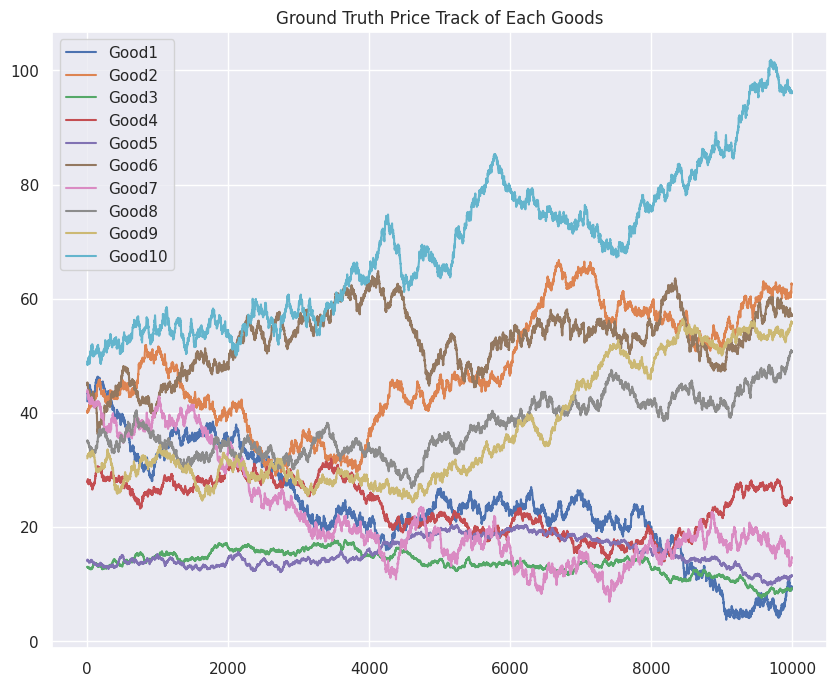

In [256]:
# let ground truth price p be a Brownian Montion
np.random.seed(0)
P = np.zeros((n,m))
fig, ax = plt.subplots(figsize=[10, 8])
for i in range(m):
  gen_p = Brownian(p[i], p[i]/2)
  # now the ground truth price is fluctuate
  p_new = gen_p.gen_normal(n)
  P[:,i] = p_new
  plt.plot(p_new)
plt.title('Ground Truth Price Track of Each Goods')
plt.legend([f'Good{i+1}' for i in range(m)])
plt.show()
# adjust pi according to ground truth price

In [259]:
pi_new = np.sum(P*A.T, axis=1).reshape(-1,1).astype(float) + random.gauss(0, 0.2)

In [260]:
print(f'The shape of A     :  {A.shape}')
print(f'The shape of pi_new:  {pi_new.shape}')
print(f'The shape of b     :  {b.shape}')
print(f'The dtype of A     :  {A.dtype}')
print(f'The dtype of pi_new:  {pi_new.dtype}')
print(f'The dtype of b     :  {b.dtype}')

The shape of A     :  (10, 10000)
The shape of pi_new:  (10000, 1)
The shape of b     :  (10, 1)
The dtype of A     :  int64
The dtype of pi_new:  float64
The dtype of b     :  float64


## Previous Algorithm Applied to Dependent Data

### Offline Learning

In [261]:
x = cp.Variable((n,1))
objective = cp.Maximize(pi_new.T@x)
constraints = [A@x <= b, x >= 0, x <= 1]
prob = cp.Problem(objective, constraints)

prob.solve()

opv2 = prob.value
x = np.where(x.value >= 0.5, 1, 0)

print(f'Optimal Solution: \n{x[:,0].T}')
print(f'Optimal Value: {opv2}')

Optimal Solution: 
[0 0 0 ... 1 1 0]
Optimal Value: 388175.1592895987


### One-time Online Learning (SLPM)

In [262]:
print('-'*25 + 'One-time Online Learning SLPM' + '-'*25 + '\n')
for k in [50, 100, 200]:
  P_ol_slpm_dpt, x_ol_slpm_dpt, r_ol_slpm_dpt = online_learning_SLPM(A,pi_new,b,10000,k)
  print('-'*25 + f'k = {k}' + '-'*25 + '\n')
  print(f'Dual price: {P_ol_slpm_dpt.T[0,:]} \n')
  print(f'Allocation: {x_ol_slpm_dpt.T[0,:]} \n')
  print(f'Revenue: {r_ol_slpm_dpt} \n')
  print(f'Ratio: {r_ol_slpm_dpt/opv2} \n')

-------------------------One-time Online Learning SLPM-------------------------

-------------------------k = 50-------------------------

Dual price: [44.1172563  40.47505796 13.05239202 27.82502033 14.46094933 44.36894089
 41.92443951 33.88702653 32.65667172 49.82944742] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 289662.61664250033 

Ratio: 0.746216262711435 

-------------------------k = 100-------------------------

Dual price: [43.55652274 41.32288004 12.45449442 27.35015596 14.56503144 44.00392798
 41.77610045 33.76717803 32.90530176 50.76810903] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 293690.980106796 

Ratio: 0.7565939578521237 

-------------------------k = 200-------------------------

Dual price: [44.92890828 42.77302011 13.14143464 29.09929002 14.21024153 41.93478178
 42.09307475 33.85702304 31.78678937 50.5390655 ] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 285632.3939233362 

Ratio: 0.735833777839039 



### Dynamic Learning (SLPM)

In [263]:
P_dl_slpm_dpt, x_dl_slpm_dpt, r_dl_slpm_dpt = dynamic_learning_SLPM(A, pi_new, b, 10000, 50)

------------------------------The Track of Dual Price------------------------------

-------------------------k = 50 -------------------------

Dual price: [44.1172563  40.47505796 13.05239202 27.82502033 14.46094933 44.36894089
 41.92443951 33.88702653 32.65667172 49.82944742]

-------------------------k = 100 -------------------------

Dual price: [43.55652274 41.32288004 12.45449442 27.35015596 14.56503144 44.00392798
 41.77610045 33.76717803 32.90530176 50.76810903]

-------------------------k = 200 -------------------------

Dual price: [44.92890828 42.77302011 13.14143464 29.09929002 14.21024153 41.93478178
 42.09307475 33.85702304 31.78678937 50.5390655 ]

-------------------------k = 400 -------------------------

Dual price: [43.95981809 43.50164364 13.43129541 28.31513509 13.59923269 42.06785722
 41.02008104 34.45870844 31.62849745 50.86750836]

-------------------------k = 800 -------------------------

Dual price: [40.8165094  44.47011803 14.20692918 27.7256612  14.01048339

In [264]:
print('-'*30 + 'Dynamic Learning SCLM' + '-'*30 + '\n')
print(f'Dual price: {P_dl_slpm_dpt.T[0,:]} \n')
print(f'Allocation: {x_dl_slpm_dpt.T[0,:]} \n')
print(f'Revenue: {r_dl_slpm_dpt} \n')
print(f'Ratio: {r_dl_slpm_dpt/opv2} \n')

------------------------------Dynamic Learning SCLM------------------------------

Dual price: [32.15662111 44.7446484  15.47938867 27.00721011 15.80557132 50.91525434
 31.2480005  34.7906677  31.59767278 61.7923568 ] 

Allocation: [0. 0. 0. ... 0. 0. 0.] 

Revenue: 311315.3989387841 

Ratio: 0.8019972208126969 



### One-time Online Learning (SCPM)

In [265]:
print('-'*25 + 'One-time Online Learning SCPM' + '-'*25 + '\n')
for k in [50, 100, 200]:
  P_ol_scpm_dpt, x_ol_scpm_dpt, r_ol_scpm_dpt = online_learning_SCPM(A,pi_new,b,10000,k,1)
  print('-'*25 + f'k = {k}' + '-'*25 + '\n')
  print(f'Dual price: {P_ol_scpm_dpt.T[0,:]} \n')
  print(f'Allocation: {x_ol_scpm_dpt.T[0,:]} \n')
  print(f'Revenue: {r_ol_scpm_dpt} \n')
  print(f'Ratio: {r_ol_scpm_dpt/opv2} \n')

-------------------------One-time Online Learning SCPM-------------------------

-------------------------k = 50-------------------------

Dual price: [44.10226036 40.4750672  13.03739942 27.83999276 14.47596993 44.38392626
 41.91692142 33.89451755 32.66413076 49.81450617] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 289780.885529241 

Ratio: 0.7465209418850255 

-------------------------k = 100-------------------------

Dual price: [43.57284252 41.32683699 12.45366707 27.32937376 14.58727596 44.00365558
 41.75452147 33.7757748  32.90584929 50.78554972] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 293561.4331037437 

Ratio: 0.7562602244847196 

-------------------------k = 200-------------------------

Dual price: [44.96981643 42.77228753 13.14220453 29.09960785 14.25130078 41.93496542
 42.09320394 33.8154055  31.78736114 50.49755388] 

Allocation: [0 0 0 ... 0 0 0] 

Revenue: 285429.8086024523 

Ratio: 0.7353118863268293 



### Dynamic Learning (SCPM)

In [266]:
P_dl_scpm_dpt, x_dl_scpm_dpt, r_dl_scpm_dpt = dynamic_learning_SCPM(A, pi, b, 10000, 50, 1)

------------------------------The Track of Dual Price------------------------------

-------------------------k = 50 -------------------------

Dual price: [41.92338156 39.93266507 13.08516266 28.04229976 13.99425831 45.03049319
 44.00483478 35.10566977 32.07186129 48.98607429]

-------------------------k = 100 -------------------------

Dual price: [41.95154232 39.99446041 13.126772   28.04139221 13.95823589 45.02612459
 43.96471564 35.08903968 32.03306005 49.07456704]

-------------------------k = 200 -------------------------

Dual price: [41.9873758  40.07294697 13.04864637 28.03318545 14.00067572 44.99682408
 43.99985096 35.04775694 32.05333288 49.05850749]

-------------------------k = 400 -------------------------

Dual price: [42.04296933 40.05546653 13.03977378 28.05171377 14.0253611  45.05396169
 43.98220289 35.04153648 32.00936091 49.02078454]

-------------------------k = 800 -------------------------

Dual price: [42.02739567 40.03692257 13.03376007 28.0842535  14.00908146

In [267]:
print('-'*30 + 'Dynamic Learning SCPM' + '-'*30 + '\n')
print(f'Dual price: {P_dl_scpm_dpt.T[0,:]} \n')
print(f'Allocation: {x_dl_scpm_dpt.T[0,:]} \n')
print(f'Revenue: {r_dl_scpm_dpt} \n')
print(f'Ratio: {r_dl_scpm_dpt/opv2} \n')

------------------------------Dynamic Learning SCPM------------------------------

Dual price: [42.03245245 40.03431611 13.02215352 28.04882685 14.02775944 45.0311608
 44.02381648 35.03742288 32.02708104 49.02902938] 

Allocation: [0. 0. 0. ... 0. 0. 0.] 

Revenue: 332369.4468563321 

Ratio: 0.8562357453903107 



### Action-history-dependent Learning

In [ ]:
P_ahdl_dpt, x_ahdl_dpt, r_ahdl_dpt = aciton_history_dependent_learning(A, pi_new, b, 10000)

In [ ]:
print(f'Dual price: {P_ahdl_dpt.T[0,:]} \n')
print(f'Allocation: {x_ahdl_dpt.T[0,:]} \n')
print(f'Revenue: {r_ahdl_dpt} \n')
print(f'Ratio: {r_ahdl_dpt/opv1} \n')

### Dynamic Online Learning with SGD